In [40]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')

In [41]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm
def calculate_flux_density(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_intensity(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

In [42]:
def CountPixel(img, x, y, boundary, lenth = 30):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    return len(np.where(img > boundary)[0])

In [43]:
def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [44]:
with open("BOSS0042_NB.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('BOSS0042_NB.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [45]:
with open("BOSS0042_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('BOSS0042_Bw.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [46]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS_Bw=pd.read_csv("BOSS0042_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS_NB=pd.read_csv("BOSS0042_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])

In [47]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)


SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']

In [48]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
coord_bw=SkyCoord(ra=BOSS_Bw['ALPHA_J2000']*u.degree, dec=BOSS_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS_NB['ALPHA_J2000']*u.degree, dec=BOSS_NB['DELTA_J2000']*u.degree)

In [49]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)
index = np.where((d2d < Angle('0d00m01s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))
idx=idx[index]

In [50]:
SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj
SDSS6_bmag=SDSS6.bmag.data.obj
BOSS_Bw_list=BOSS_Bw.MAG_APER.data.obj
BOSS_Bw_list_standard=BOSS_Bw.MAG_APER.data.obj[idx]

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.data is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be rem

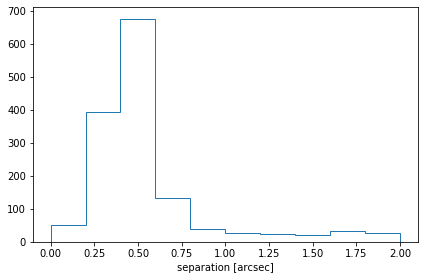

In [51]:
plt.hist(d2d.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()

In [52]:
SDSS6_bmag_standard=SDSS6_bmag[index]
zeropoint_bw=SDSS6_bmag_standard-BOSS_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

Bw的zeropoint为 25.90484839205298
Bw的standard deviation为 0.08832152814664958


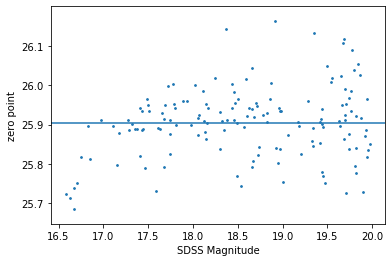

In [53]:
# zeropoint_bw.zeropoint_bw.data.obj
zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation


print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')

plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)

plt.show()

In [54]:
BOSS_Bw=pd.concat([BOSS_Bw,BOSS_Bw.MAG_APER+zp_bw],axis=1)
BOSS_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [55]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)
index_nb = np.where(d2d_nb < Angle('0d0m01s'))
idx_nb=idx_nb[index_nb]

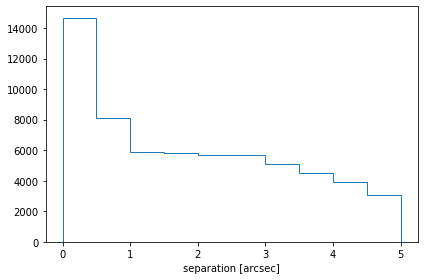

In [56]:
plt.hist(d2d_nb.arcsec, histtype='step', range=(0,5))
plt.xlabel('separation [arcsec]')
plt.tight_layout()

In [57]:
BOSS_NB_match = BOSS_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS_NB_match < 5) &(BOSS_NB_match > -3))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.data is deprecated and will be removed in a future version
  


In [58]:
zp_nb=np.mean(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))
zp_std_nb=np.std(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.data is deprecated and will be removed in a future version
  if __name__ == '__main__':


NB的zeropoint为 22.505937967342557
NB的standard deviation为 0.0030234488050508014


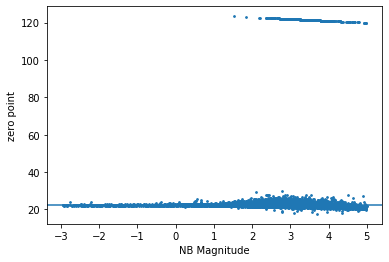

In [59]:

print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

BOSS_NB=pd.concat([BOSS_NB,BOSS_NB.MAG_APER+zp_nb],axis=1)
BOSS_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

BOSS_NB_match=BOSS_NB_match+zp_nb

b_nb=BOSS_Bw.standard_mag.data.obj[idx_nb]-BOSS_NB_match
mag_nb_draw=BOSS_NB_match

plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')

plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)

plt.show()

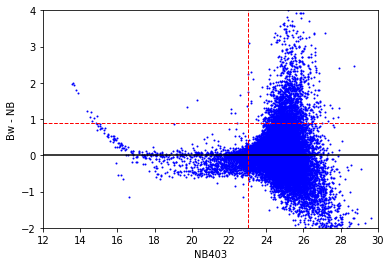

In [60]:
plt.scatter(mag_nb_draw, b_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(23, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [61]:
BOSS_Bw_ALPHA=BOSS_Bw.ALPHA_J2000.data.obj[idx_nb]
BOSS_Bw_DELTA=BOSS_Bw.DELTA_J2000.data.obj[idx_nb]
BOSS_Bw_X_IMAGE=BOSS_Bw.X_IMAGE.data.obj[idx_nb]
BOSS_Bw_Y_IMAGE=BOSS_Bw.Y_IMAGE.data.obj[idx_nb]
BOSS_Bw_ISOAREAF_IMAGE=BOSS_Bw.ISOAREAF_IMAGE.data.obj[idx_nb]

BOSS_NB_ALPHA=BOSS_NB.ALPHA_J2000.data.obj[index_nb]
BOSS_NB_DELTA=BOSS_NB.DELTA_J2000.data.obj[index_nb]
BOSS_NB_X_IMAGE=BOSS_NB.X_IMAGE.data.obj[index_nb]
BOSS_NB_Y_IMAGE=BOSS_NB.Y_IMAGE.data.obj[index_nb]
BOSS_NB_ISOAREAF_IMAGE=BOSS_NB.ISOAREAF_IMAGE.data.obj[index_nb]

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.data is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be rem

In [62]:
BOSS_Bw_X_IMAGE_dubious=[]
BOSS_Bw_Y_IMAGE_dubious=[]
BOSS_Bw_RA_dubious=[]
BOSS_Bw_DEC_dubious=[]
BOSS_Bw_mag_dubious=[]
BOSS_Bw_AREA_dubious=[]

BOSS_NB_X_IMAGE_dubious=[]
BOSS_NB_Y_IMAGE_dubious=[]
BOSS_NB_RA_dubious=[]
BOSS_NB_DEC_dubious=[]
BOSS_NB_mag_dubious=[]
BOSS_NB_AREA_dubious=[]

for i in range(len(idx_nb)):
    if (BOSS_Bw.standard_mag.data.obj[idx_nb][i]-BOSS_NB_match[i] > 0.9) \
        & (BOSS_NB_match[i]< 23):
        BOSS_Bw_X_IMAGE_dubious.append(BOSS_Bw_X_IMAGE[i])
        BOSS_Bw_Y_IMAGE_dubious.append(BOSS_Bw_Y_IMAGE[i])
        BOSS_Bw_RA_dubious.append(BOSS_Bw_ALPHA[i])
        BOSS_Bw_DEC_dubious.append(BOSS_Bw_DELTA[i])
        BOSS_Bw_mag_dubious.append(BOSS_Bw.standard_mag.data.obj[idx_nb][i])
        BOSS_Bw_AREA_dubious.append(BOSS_Bw_ISOAREAF_IMAGE[i])
        
        BOSS_NB_X_IMAGE_dubious.append(BOSS_NB_X_IMAGE[i])
        BOSS_NB_Y_IMAGE_dubious.append(BOSS_NB_Y_IMAGE[i])
        BOSS_NB_RA_dubious.append(BOSS_NB_ALPHA[i])
        BOSS_NB_DEC_dubious.append(BOSS_NB_DELTA[i])
        BOSS_NB_mag_dubious.append(BOSS_NB_match[i])
        BOSS_NB_AREA_dubious.append(BOSS_NB_ISOAREAF_IMAGE[i])

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.data is deprecated and will be removed in a future version
  app.launch_new_instance()
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.data is deprecated and will be removed in a future version


In [63]:
w = WCS('BOSS0042_Bw_cut.fits')
data,header=fits.getdata('BOSS0042_Bw_cut.fits',header=True)
data2,header2=fits.getdata('BOSS0042_NB_cut.fits',header=True)
lenx=len(data[0])
leny=len(data)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
norm = Scaleimgconverter(datacut)

In [64]:
x_select=[]
y_select=[]
ra_select=[]
dec_select=[]
mag_nb_select=[]
mag_bw_select=[]
area_select=[]
bw_area_select=[]

for i in range(len(BOSS_NB_X_IMAGE_dubious)):
    if (BOSS_NB_AREA_dubious[i]>25) and (choose(datacut,BOSS_NB_X_IMAGE_dubious[i],BOSS_NB_Y_IMAGE_dubious[i],-10,40)):
        x_select.append(BOSS_NB_X_IMAGE_dubious[i])
        y_select.append(BOSS_NB_Y_IMAGE_dubious[i])
        ra_select.append(BOSS_NB_RA_dubious[i])
        dec_select.append(BOSS_NB_DEC_dubious[i])
        mag_nb_select.append(BOSS_NB_mag_dubious[i])
        mag_bw_select.append(BOSS_Bw_mag_dubious[i])
        area_select.append(BOSS_NB_AREA_dubious[i])
        bw_area_select.append(BOSS_Bw_AREA_dubious[i])
        
print(len(x_select))

7


In [65]:
def show_nebula(img1,img2,img3,x,y,size):
    center=[np.array([x],float),np.array([y],float)]
    cutout1=Cutout2D(data, center,30, wcs = WCS(header))
    cutout2=Cutout2D(data2, center,30, wcs = WCS(header))
    cutout3=Cutout2D(datacut, center,30, wcs = WCS(header))
  
    norm1 = Scaleimgconverter(img1)
    norm2 = Scaleimgconverter(img2)
    norm3 = Scaleimgconverter(img3)

    x = x.astype(int)
    y = y.astype(int)
    x1=x-size
    x2=x+size
    y1=y-size
    y2=y+size
    fig = plt.figure()
    ax = plt.subplot(131,projection=cutout1.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img1[y1:y2,x1:x2],norm=norm1,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')
    
    fig = plt.figure()
    ax = plt.subplot(132,projection=cutout2.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img2[y1:y2,x1:x2],norm=norm2,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

    fig = plt.figure()
    ax = plt.subplot(133,projection=cutout3.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img3[y1:y2,x1:x2],norm=norm3,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

In [66]:
nb_flux=[]
bw_flux=[]

for i in range(len(mag_nb_select)):
    nb_flux.append(calculate_flux(mag_nb_select[i],4030,45))
    
for i in range(len(mag_bw_select)):
    bw_flux.append(calculate_flux(mag_bw_select[i],4135,1278))

In [67]:
line_flux=[]
for i in range(len(nb_flux)):
    line_flux.append(calculate_continuum_subtracted_line_flux(bw_flux[i],nb_flux[i],1278,48))

In [68]:
distance=calculate_distance(2.3)

In [69]:
lya_luminosity=[]
for i in range(len(mag_nb_select)):
    lya_luminosity.append(4*math.pi*distance**2*line_flux[i])
print(lya_luminosity)

[2.5889430654606514e+42, 3.4768399927772517e+42, 2.1052101719927826e+43, 2.79404093295425e+42, 3.2555327631519895e+43, 3.54338883080219e+42, 1.6319586362432677e+42]


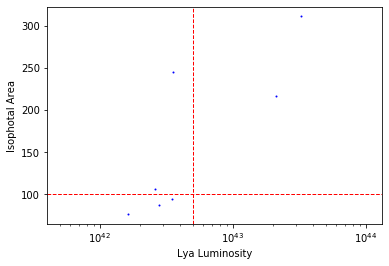

In [70]:
plt.semilogx()
plt.scatter(lya_luminosity,area_select, color = 'b', s=1)
plt.axhline(100, color='r', linestyle='--', linewidth = 1)
plt.axvline(5e42, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

In [71]:
x_final=[]
y_final=[]
ra_final=[]
dec_final=[]
mag_nb_final=[]
mag_bw_final=[]
area_nb_final=[]
area_bw_final=[]

for i in range(len(x_select)):
    if (lya_luminosity[i]> 5e42) and (area_select[i]> 100):
        x_final.append(x_select[i])
        y_final.append(y_select[i])
        ra_final.append(ra_select[i])
        dec_final.append(dec_select[i])
        mag_nb_final.append(mag_nb_select[i])
        mag_bw_final.append(mag_bw_select[i])
        area_nb_final.append(area_select[i])
        area_bw_final.append(bw_area_select[i])
print(len(x_final))

2


In [72]:
surface_brightness_bw=[]
surface_brightness_nb=[]
for i in range(len(x_final)):
    surface_brightness_bw.append(mag_bw_final[i]+2.5*math.log(area_bw_final[i]*0.0624979,10))
    surface_brightness_nb.append(mag_nb_final[i]+2.5*math.log(area_nb_final[i]*0.0624979,10))

x_image: 5458.1724 

y_image: 4907.6587 

RA: 10.4149905 

DEC: 11.987903900000001 

nb_magnitude 20.286537967342557 

bw_magnitude: 21.81404839205298 

surface_brightness_bw: 23.926757010739255 

surface_brightness_nb: 23.1173508639747 



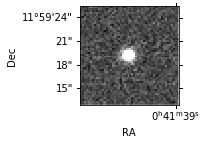

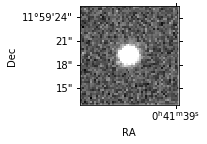

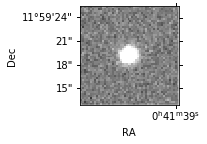

In [73]:
show_nebula(data,data2,datacut,x_final[0],y_final[0],25)
print('x_image:',x_final[0],'\n')
print('y_image:',y_final[0],'\n')
print('RA:',ra_final[0],'\n')
print('DEC:',dec_final[0],'\n')
print('nb_magnitude',mag_nb_final[0],'\n')
print('bw_magnitude:', mag_bw_final[0],'\n')
print('surface_brightness_bw:',surface_brightness_bw[0],'\n')
print('surface_brightness_nb:',surface_brightness_nb[0],'\n')

x_image: 3677.717 

y_image: 5667.2476 

RA: 10.5414478 

DEC: 12.040542599999998 

nb_magnitude 19.74473796734256 

bw_magnitude: 21.08774839205298 

surface_brightness_bw: 23.73945651158764 

surface_brightness_nb: 22.96630250192047 



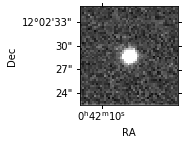

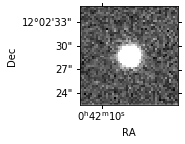

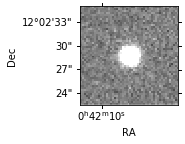

In [74]:
show_nebula(data,data2,datacut,x_final[1],y_final[1],25)
print('x_image:',x_final[1],'\n')
print('y_image:',y_final[1],'\n')
print('RA:',ra_final[1],'\n')
print('DEC:',dec_final[1],'\n')
print('nb_magnitude',mag_nb_final[1],'\n')
print('bw_magnitude:', mag_bw_final[1],'\n')
print('surface_brightness_bw:',surface_brightness_bw[1],'\n')
print('surface_brightness_nb:',surface_brightness_nb[1],'\n')

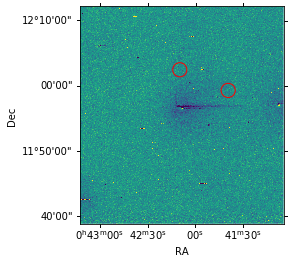

<Figure size 432x288 with 0 Axes>

In [75]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

ax.scatter(x_final, y_final, color='', marker='o', edgecolors='r', s=200)

In [76]:
with open("BOSS0042_coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(mag_nb_final)):
        if (mag_bw_final[i]-mag_nb_final[i] > 0.9) \
        & (mag_nb_final[i]< 23.5):
            txtfile.write('circle(')
            txtfile.write(str(ra_final[i]))
            txtfile.write(',')
            txtfile.write(str(dec_final[i]))
            txtfile.write(',2.821")\n')

In [77]:
x_emitter=[]
y_emitter=[]
ra_emitter=[]
dec_emitter=[]

for i in range(len(BOSS_NB_X_IMAGE_dubious)):
    if choose(datacut,BOSS_NB_X_IMAGE_dubious[i],BOSS_NB_Y_IMAGE_dubious[i],-10,30):
        x_emitter.append(BOSS_NB_X_IMAGE_dubious[i])
        y_emitter.append(BOSS_NB_Y_IMAGE_dubious[i])
        ra_emitter.append(BOSS_NB_RA_dubious[i])
        dec_emitter.append(BOSS_NB_DEC_dubious[i])

10.338013290000001 10.704303809999999 11.78968399 12.13735771


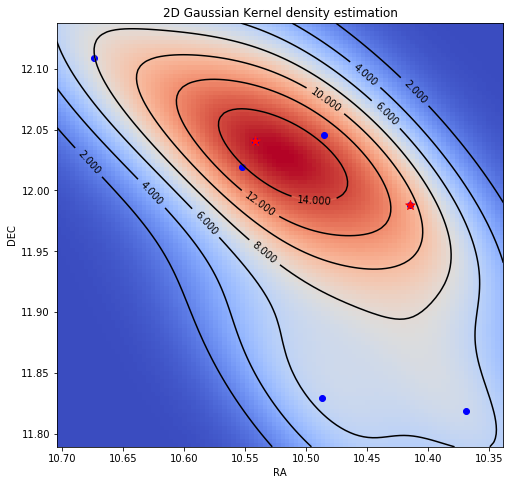

In [79]:
# Extract x and y
x = ra_emitter
y = dec_emitter
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = sta.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmax, xmin)
ax.set_ylim(ymin, ymax)
cfset = ax.contour(xx, yy, f, cmap='coolwarm')
ax.scatter(ra_emitter,dec_emitter,c='b')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
plt.title('2D Gaussian Kernel density estimation')

ax.scatter(ra_final,dec_final, c='r', s=100, marker='*')